In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff8 as ds
import diffusionstuff7 as dsOld
from copy import copy as dup
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from numba import int64
from numba import int32

#for 3d plots
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

#for saving animations
import pickle
from matplotlib import animation
from IPython.display import HTML



In [2]:
# Graphics parameters
%matplotlib inline
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [56]:
# Number of iterations to calculate Nliq from Ntot
niter = 1

# simulation timesteps
tinterval = np.arange(0,200000,1000)

# Message
print("Starting a new system")
nx = 512 # Number of points in simulation box
xmax = 50
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltaX = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Lay out the system
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]

# Initialize as a pre-equilibrated layer of liquid over ice
Nice0 = np.ones(boxpoints) # begin with one layer of ice
#Adding noise to test stability of system (-Max, 6/27/2020)
#Nice += np.random.normal(0,0.01,nx)

NQLL0 = Nbar + Nstar * np.sin(2*np.pi*(Nice0 - Nbar)) # initialize quasi-liquid layer  
Ntot0 = NQLL0 + Nice0

Starting a new system


In [57]:
#Time and diffusion parameters
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 #-0.10 # Must be bigger than sigma0 to get growth, less than 0 for ablation
center_reduction = 0.25 #0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax)

In [58]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec') # diffusion
print('deprate =', deprate, 'monolayers/us') # deposition rate
print('nmid', nmid) # midpoint
print('N*', Nstar) # N^*
print('N*x2pi', Nstar*2*np.pi) # 2 pi N^*
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar) # N average (what is N?) and deviation
print('deltaX', deltaX) # spatial step size
print('sigma_0 =', sigma0) # supersaturation default
print('sigmastepmax =', sigmastepmax) # deviation from default
print('center reduction', center_reduction, '%') # reduction of supersaturation in the center
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec') # max growth rate (edge)
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec') # min growth rate (center)
print('nu_kin =', nu_kin, 'um/sec') # nu-kinetic

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deprate = 0.16333333333333333 monolayers/us
nmid 256
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.09784735812133072
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


In [59]:
# This is the 1-d run
# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array([0,nx])

# Initial conditions for ODE solver

#out = solve_ivp(ds.f1d, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = Ntot0-NQLL0, args=(float_params,sigmastep),rtol=1e-12)
out2 = solve_ivp(dsOld.f1d, t_span = [tinterval[0],tinterval[-1]], t_eval = tinterval, y0 = np.concatenate([NQLL0,Ntot0]), args=(float_params,int_params,sigmastep),rtol=1e-12)

In [43]:
from numba import njit, float64, types

def diffuse_1dOld(Fliq0,DoverdeltaX2):
    l = len(Fliq0)
    dy = np.zeros((l,))#np.shape(Fliq0))
    for i in range(1,l-1):#(1,l-1):
        dy[i] = DoverdeltaX2*(Fliq0[i+1]-2*Fliq0[i]+Fliq0[i-1])
    # Boundary Conditions (periodic at ends)
    dy[0] = DoverdeltaX2*(Fliq0[1]-2*Fliq0[0]+Fliq0[l-1]) 
    dy[l-1] = DoverdeltaX2*(Fliq0[0]-2*Fliq0[l-1]+Fliq0[l-2])
    return dy

def f1dOld(t, y, float_params, int_params, sigmastep): #sigmastep is an array
    """ odeint function for the one-dimensional ice model """
     # unpack parameters
    Nbar, Nstar, sigma0, deprate, DoverdeltaX2 = float_params 
    niter, nx = int_params

    # unpack current values of y
    Fliq0, Ntot0 = np.reshape(np.ascontiguousarray(y),(types.int32(2),types.int32(nx)))
    
    delta = (Fliq0 - (Nbar - Nstar))/(2*Nstar)
    sigD = (sigmastep - delta * sigma0)/(1+delta*sigma0)
    depsurf = deprate * sigD
    dFliq0_dt = getdNliq_dNtot_array(Ntot0,Nstar,Nbar,niter)*depsurf
    dNtot_dt = depsurf
    dNtot_dt = 0*dNtot_dt

    # Diffusion
    dy = diffuse_1dOld(Fliq0,DoverdeltaX2)
     
    # Combined
    dFliq0_dt += dy
    dNtot_dt += dy 

    # Package for output
    #derivs = np.reshape(np.array([[*dFliq0_dt], [*dNtot_dt]]),2*nx) #need to unpack lists back into arrays of proper shape (2,nx) before reshaping
    #derivs = np.reshape(np.stack((dFliq0_dt,dNtot_dt),axis=0),2*nx)
    return Fliq0

def getdNliq_dNtot_array(Ntot,Nstar,Nbar,niter):
    dfqll_dNtot_last = np.zeros(np.shape(Ntot)[0])
    fqll_last = np.ones(np.shape(Ntot)[0])
    for i in range(niter):
        dfqll_dNtot_last = getdfqll_dNtot_next_array(dfqll_dNtot_last,fqll_last,Ntot,Nstar,Nbar)
        fqll_last = fqll_next_array(fqll_last,Ntot,Nstar,Nbar)
    return dfqll_dNtot_last*Nbar 







def diffuse_1dNew(Fliq0,DoverdeltaX2):
    l = len(Fliq0)
    print(l)
    dy = np.zeros((l,))#np.shape(Fliq0))
    for i in range(1,-1):#(1,l-1):
        dy[i] = DoverdeltaX2*(Fliq0[i+1]-2*Fliq0[i]+Fliq0[i-1])
    # Boundary Conditions (periodic at ends)
    dy[0] = DoverdeltaX2*(Fliq0[1]-2*Fliq0[0]+Fliq0[l-1]) 
    dy[l-1] = DoverdeltaX2*(Fliq0[0]-2*Fliq0[l-1]+Fliq0[l-2])
    return dy

def f1dNew(t, Ntot, float_params, sigmastep): #sigmastep is an array
    """ odeint function for the one-dimensional ice model """
     # unpack parameters
    Nbar, Nstar, sigma0, deprate, DoverdeltaX2 = float_params

    # compute quasi-liquid layer from Ntot
    NQLL = Nbar + Nstar * np.sin(2*np.pi*(Ntot - Nbar))
    
    delta = (NQLL - (Nbar - Nstar))/(2*Nstar)
    sigD = (sigmastep - delta * sigma0)/(1+delta*sigma0)
    depsurf = deprate * sigD
    dNtot_dt = depsurf
    dNtot_dt = 0*dNtot_dt

    # Diffusion
    dy = diffuse_1dNew(NQLL,DoverdeltaX2)
     
    # Combined
    dNtot_dt += dy
    return NQLL









float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array([0,nx])


Nice0Rand = np.random.random(Ntot0.shape)
NQLL0Rand = Nbar + Nstar * np.sin(2*np.pi*(Nice0Rand - Nbar))
Ntot0Rand = Nice0Rand + NQLL0Rand

initialDerivNew = f1dNew(0,Nice0Rand, float_params, sigmastep)
initialDerivOld = f1dOld(0, np.concatenate([NQLL0Rand,Ntot0Rand]), float_params, int_params, sigmastep)

initialDerivNew - initialDerivOld

#p = plt.plot(initialDerivNew)
#p += plt.plot(initialDerivOld)
#p

512


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [52]:
out2.y.shape

(1024, 200)

Height of Ice 3102.9163429875844
1-D growth, corner 3116.2969176154274
1-D growth, center 3101.9163429875844
1-D Modeled growth rate, corner, um/s 46.97935051681549
1-D Modeled growth rate, corner, ml/us 0.15659783505605163
1-D Modeled growth rate, center, um/s 46.762557934486196
1-D Modeled alpha, corner 4.794183618185919
1-D Modeled alpha, center 4.7836486610050075
Difference, % -0.21974454922729028
Libbrecht's predicted growth rate, um/s 1.8393582063217946
Libbrecht's predicted alpha 0.18768961288997904


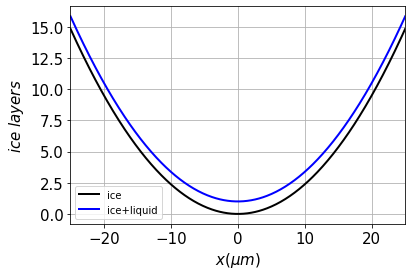

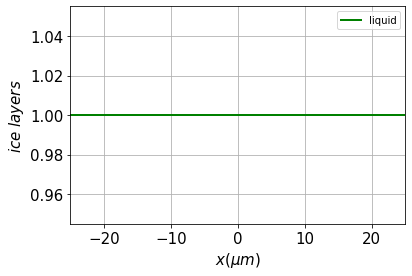

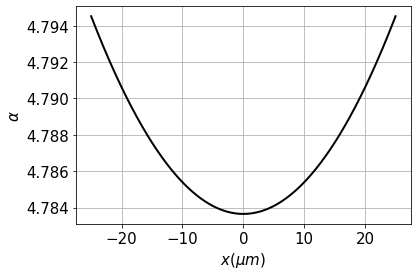

In [60]:
NQLL = out2.y[0:nx]
Ntot = out2.y[nx:]
Nice = Ntot - NQLL
#Ntot = out.y
#NQLL = Nbar + Nstar * np.sin(2*np.pi*(Ntot - Nbar))
#Nice = Ntot - NQLL

NtotFinal = Ntot[:,-1]
NQLLFinal = NQLL[:,-1]
NiceFinal = Nice[:,-1]


# Growth statistics
minpoint = min(NiceFinal)
ncorner = 4 # why is ncorner 4 and not 0?

# total height of ice
print("Height of Ice", minpoint)

 # change in total ice depth at each grid point
delta_Ntot_entire = NtotFinal-Ntot[:,0]

# growth at corner and in center
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])

# growth over time (growth rate)
growthrate_entire = delta_Ntot_entire/out.t[-1]*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus) # why different units on this one?
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])

# alpha is some other modified growth rate
alpha = growthrate_entire/nu_kin/sigmastep
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

#########
# Plots #
#########

# First plot: layers (rescaled to have minimum at zero, shifted so center of facet is at zero)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, NiceFinal-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, NtotFinal-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Second plot: liquid layer alone
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, NQLLFinal, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Third plot: alpha (a measure of growth rate at each point)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')


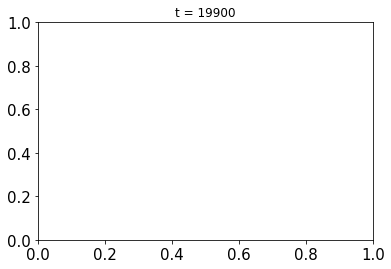

In [55]:
timesteps = out.y.shape[1]
    

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = x[0]-xmid,xmax = x[-1]-xmid,ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(x-xmid,Ntot[:,n] - min(Nice[:,n]))
    lineList[1][0].set_data(x-xmid,Nice[:,n] - min(Nice[:,n]))
    plt.title('t = '+str(round(out.t[n],1)))
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(out.t))

plt.close()
HTML(anim.to_jshtml())

In [7]:
NiceAlt = np.ones(nx)
Fliq = dsOld.getNliq_array(NiceAlt,Nstar,Nbar,niter)

# This is the 1-d run
# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array(list(map(int32,[niter,nx])))

# Initial conditions for ODE solver
y0 = np.array([Fliq,NiceAlt + Fliq])
ylast = dup(y0)
tlast = tinterval[0]

# Initialize the keeper arrays
tkeep = [tinterval[0]]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
updatingFliq = True # seems to be neccesary for expected 1d model behavior
counter = 0
lastlayer = 0
lastdiff = 0
ttot = tinterval[0]

trajflag = False
uselayers = False

tintervalAlt = [0, deltaT]
countermax_1D = 10

while True:
    # Integrate up to next time step
    y = odeint(dsOld.f1d, np.reshape(ylast,2*nx), tintervalAlt, args=(float_params,int_params,sigmastep),rtol=1e-12, tfirst = True)

    ylast = np.reshape(y[1],(2,nx))
    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = dsOld.getNliq_array(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltaT

    # Stuff into keeper arrays if requested
    if trajflag:
        Nicekeep.append(Nice)
        Ntotkeep.append(Ntot)
        Fliqkeep.append(Fliq)
        tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
        
    # Test whether we're finished
    if uselayers:
        if sigmastepmax > 0:
            if layer > layermax_1D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_1D:
                print('breaking because reached max number of layers ablated')
                break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

NameError: name 'Nice' is not defined

In [18]:
plt.plot(Ntot - min(Ntot))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
import scipy as sp

def fftnorm(u_full):
    """Computes normalized FFT (such that FFT and IFFT are symmetrically normalized)
    
    Parameters
    ----------
    u_full : 1D Numpy Array (N,)
        The vector whose discrete FFT is to be computed

    Returns
    -------
    normalizedFFT : 1D Numpy Array (N,)
        The transformed version of that vector
    """

    normalizedFFT = np.fft.rfft(u_full,norm = "forward")
    return normalizedFFT

def ifftnorm(u_full):
    """Computes normalized IFFT (such that FFT and IFFT are symmetrically normalized)
    
    Parameters
    ----------
    u_full : 1D Numpy Array (N,)
        The vector whose discrete IFFT is to be computed

    Returns
    -------
    normalizedIFFT : 1D Numpy Array (N,)
        The transformed version of that vector
    """
    

    normalizedIFFT = np.fft.irfft(u_full, norm = "forward")
    return normalizedIFFT

def convolution(nT,depsurf,Nstar):
    """Computes Fourier transform of the nonlinear term in the QLL PDE
    
    2 pi N^* sigmaM vKin cos(Ntot)
    
    Computed in real space and then converted back
    to Fourier space.
    
    Parameters
    ----------
    nT : 1D Numpy Array (N,)
        Total water layers
        
    nu_kin : TBD
        TBD
        
    sigmastep : TBD
        TBD
        
    Nstar : TBD
        TBD

    Returns
    -------
    convo : 1D Numpy Array (N,)
        Fourier transform of the nonlinear term
    """
    
    # compute double sum in real space, then apply scalar multiplier
    convo = fftnorm(2 * np.pi * Nstar *depsurf * np.cos(2*np.pi*ifftnorm(nT)))
    return convo

def nTotRHS(nQLL,depsurf,k,D):
    """Computes RHS of the ODE for the positive modes of Ntot
    
    dnk/dt = -k^2 D nkQLL + 2 pi FFT(sigma_m) nu_kin
    
    
    Parameters
    ----------
    nQLL : 1D Numpy Array (N,)
        Positive modes of state vector for quasi-liquid layers
        
    nu_kin : TBD
        TBD
        
    sigmastep_FFT : TBD
        TBD
        
    k : 1D Numpy Array (N,)
        Vector of wavenumbers
        
    D : float
        Diffusion coefficient

    Returns
    -------
    dnTot : 1D Numpy Array (N,)
        Rate of change of positive modes of nTot
    """


    dnTot = -k**2 * D * nQLL + fftnorm(depsurf)
    
    return dnTot

def nQLLRHS(nTot,nQLL,depsurf,k,D,Nstar):
    """Computes RHS of the ODE for the positive modes of Ntot
    
    dn0/dt = 2 * pi * sigma_m * nu_kin
    dnk/dt = -k^2 D nkQLL
    
    
    Parameters
    ----------
    nTot : 1D Numpy Array (N,)
        Positive modes of state vector for total layers
    
    nQLL : 1D Numpy Array (N,)
        Positive modes of state vector for quasi-liquid layers
        
    nu_kin : TBD
        TBD
        
    sigmastep_FFT : TBD
        TBD
        
    k : 1D Numpy Array (N,)
        Vector of wavenumbers
        
    D : float
        Diffusion coefficient
        
    Nstar : float
        TBD

    Returns
    -------
    dnQLL : 1D Numpy Array (N,)
        Rate of change of positive modes of nTot
    """
    
    convo = convolution(nTot,depsurf,Nstar)
    #print(np.max(np.abs(convo)))

    dnQLL = -k**2 * D * nQLL + convo
    
    return dnQLL


def RHS(t,n,params):
    """
    Computes the RHS for a full KdV or ROM simulation. For use in solver.
    
    Parameters
    ----------
    t : float
        Current time
        
    n : Numpy array (2N,)
        Current state vector of positive modes (total first, then QLL)
              
    params : Dictionary
             Dictionary of relevant parameters (see below)
        N : float, number of positive modes in simulation
        nu_kin : 
        sigmastep : 
        sigmastep_FFT : 
        k : 
        D : 

        
    Returns
    -------
    RHS : 1D Numpy array (2N,)
          Derivative of each positive mode in state vector
    """
    
    # extract parameters from dictionary
    N = params['N']
    nu_kin = params['nu_kin']
    k = params['k']
    D = params['D']
    Nstar = params['Nstar']
    Nbar = params['Nbar']
    sigma0 = params['sigma0']
    sigmastep = params['sigmastep']
    deprate = params['deprate']
    
    nTot = n[0:N]
    nQLL = n[N:]
    

    delta = (ifftnorm(nQLL) - (Nbar - Nstar))/(2*Nstar)
    sigD = (sigmastep - delta*sigma0)/(1+delta*sigma0)
    depsurf = deprate*sigD
    
    
    
    
    dnT = nTotRHS(nQLL,depsurf,k,D)
    dnQ = nQLLRHS(nTot,nQLL,depsurf,k,D,Nstar)
    
    RHS = np.concatenate((dnT,dnQ))

    return RHS

def runSim(params):
    """
    Runs a simulation of the ice continuum in Fourier space
    
    Parameters
    ----------
    params : Dictionary
             Dictionary of relevant parameters (see below)
        N : float, number of positive modes in simulation
        nu_kin : 
        sigmastep : 
        sigmastep_FFT : 
        k : 
        D : 

        
    Returns
    -------
    uSim : ODE solver output
           Output solution from sp.integrate.solve_ivp (includes state vector at all timesteps, time vector, etc.)
    """
    
    # unpack parameters from dictionary
    N = params['N']
    ICNT = params['ICNT']
    ICNQLL = params['ICNQLL']
    endtime = params['endtime']
    timesteps = params['timesteps']
    
    nTotIC = fftnorm(ICNT)[0:N]
    nQLLIC = fftnorm(ICNQLL)[0:N]
    
    n = np.concatenate((nTotIC,nQLLIC))
    
    # define RHS in form appropriate for solve_ivp
    def myRHS(t,y):
        out = RHS(t,y,params)
        return out
    
    # solve the IVP
    uSim = sp.integrate.solve_ivp(fun = myRHS, t_span = [0,endtime], y0 = n, t_eval = timesteps)
    return uSim

def makeReal(fourierSol): 
    
    N = int(fourierSol.shape[0]/2)
    timesteps = fourierSol.shape[1]
    
    NTot = np.zeros((timesteps,2*N-2))
    NQLL = np.zeros((timesteps,2*N-2))
    
    for i in range(timesteps):
        NTot[i,:] = ifftnorm(fourierSol[0:N,i])
        NQLL[i,:] = ifftnorm(fourierSol[N:,i])
        
    return [NTot, NQLL]

In [15]:
N = 64
xRed = np.arange(0,50,50/(2*N-2))
sigmastepRed = ds.getsigmastep(xRed,xmax,center_reduction,sigmastepmax)


#mu = 10
#sigma = 4

#arraySize = xRed.size
#Fliq0 = 15/(sigma*np.sqrt(2*np.pi)) * np.exp(-1/2 * (xRed - mu)**2/sigma**2)
#Ntot0 = Fliq0 + 2
#deprate = 0



params = {"N" : N,
          "Nstar" : Nstar,
          "nu_kin" : nu_kin,
          "deprate" : deprate,
          "Nbar" : Nbar,
          "sigma0" : sigma0,
          "sigmastep" : sigmastepRed,
          "k" : np.arange(0,N),
          "D" : D/N,
          "ICNT" : Ntot0,
          "ICNQLL" : Fliq0,
          "endtime" : tinterval[-1],
          "timesteps" : tinterval}



outF = runSim(params)

Height of Ice -50997.07194807708
1-D growth, corner -7999.950179458456
1-D growth, center -7999.950508170827
1-D Modeled growth rate, corner, um/s 4.967864590989095
1-D Modeled growth rate, corner, ml/us 0.016559548636630315
1-D Modeled growth rate, center, um/s 4.960224803986401
1-D Modeled alpha, corner 0.5070820319944239
1-D Modeled alpha, center 0.507413841579612
Difference, % 0.06543509023244776
Libbrecht's predicted growth rate, um/s 1.8393582063217946
Libbrecht's predicted alpha 0.18768961288997904


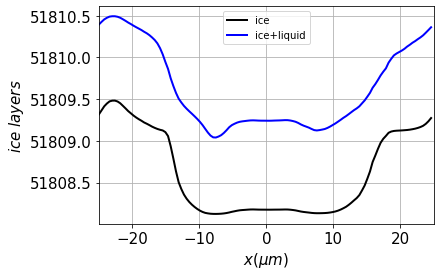

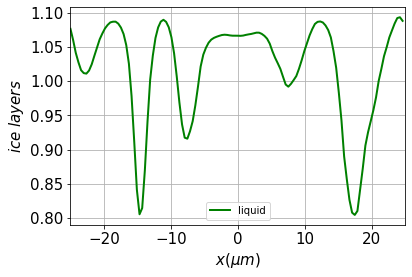

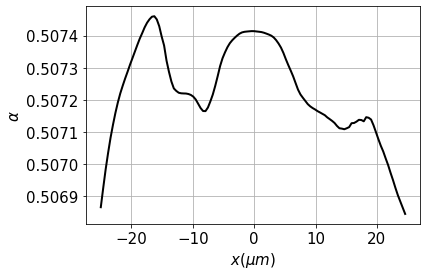

In [16]:
timesteps = outF.y.shape[1]
    
NTotF = np.zeros((timesteps,2*N-2))
NQLLF = np.zeros((timesteps,2*N-2))
    
for i in range(timesteps):
    NTotF[i,:] = ifftnorm(outF.y[0:N,i])
    NQLLF[i,:] = ifftnorm(outF.y[N:,i])

NTotF_end = NTotF[-1,:]
NQLLF_end = NQLLF[-1,:]

NiceF_end = NTotF_end - NQLLF_end

nmidF = int((NTotF[0,:]).shape[0]/2)


# Growth statistics
minpointF = min(NiceF_end)
ncorner = 4 # why is ncorner 4 and not 0?

# total height of ice
print("Height of Ice", minpoint)

 # change in total ice depth at each grid point
delta_Ntot_entireF = NTotF_end-NTotF[0,:]

# growth at corner and in center
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmidF])

# growth over time (growth rate)
growthrate_entireF = delta_Ntot_entireF/outF.t[-1]*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entireF[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entireF[ncorner]/umpersec_over_mlyperus) # why different units on this one?
print( "1-D Modeled growth rate, center, um/s", growthrate_entireF[nmidF])

# alpha is some other modified growth rate
alpha = growthrate_entireF/nu_kin/sigmastepRed
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmidF])
print( "Difference, %", (alpha[nmidF]-alpha[ncorner])/alpha[ncorner]*100)

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

#########
# Plots #
#########

# First plot: layers (rescaled to have minimum at zero, shifted so center of facet is at zero)
fignum +=1
plt.figure(fignum)
plt.plot(xRed-xmid, NiceF_end-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(xRed-xmid, NQLLF_end+NiceF_end-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Second plot: liquid layer alone
fignum +=1
plt.figure(fignum)
plt.plot(xRed-xmid, NQLLF_end, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')

# Third plot: alpha (a measure of growth rate at each point)
fignum +=1
plt.figure(fignum)
plt.plot(xRed-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')

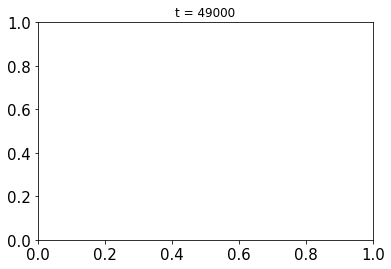

In [207]:
# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = xRed[0]-xmid,xmax = xRed[-1]-xmid,ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(4)]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(xRed - xmid,NTotF[n,:]-min(NTotF[n,:]-NQLLF[n,:]))
    #lineList[1][0].set_data(x - xmid,NTot[:,n])
    
    lineList[2][0].set_data(xRed - xmid,NTotF[n,:]-NQLLF[n,:]-min(NTotF[n,:]-NQLLF[n,:]))
    #lineList[3][0].set_data(x - xmid,NTot[:,n]-NQLL[:,n])
    plt.title('t = '+str(round(out.t[n],1)))
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(out.t))

plt.close()
HTML(anim.to_jshtml())

In [157]:
sigmastepRed

array([0.2       , 0.19937516, 0.19877047, 0.19818594, 0.19762157,
       0.19707735, 0.19655329, 0.19604938, 0.19556563, 0.19510204,
       0.1946586 , 0.19423532, 0.1938322 , 0.19344923, 0.19308642,
       0.19274376, 0.19242126, 0.19211892, 0.19183673, 0.1915747 ,
       0.19133283, 0.19111111, 0.19090955, 0.19072814, 0.19056689,
       0.1904258 , 0.19030486, 0.19020408, 0.19012346, 0.19006299,
       0.19002268, 0.19000252, 0.19000252, 0.19002268, 0.19006299,
       0.19012346, 0.19020408, 0.19030486, 0.1904258 , 0.19056689,
       0.19072814, 0.19090955, 0.19111111, 0.19133283, 0.1915747 ,
       0.19183673, 0.19211892, 0.19242126, 0.19274376, 0.19308642,
       0.19344923, 0.1938322 , 0.19423532, 0.1946586 , 0.19510204,
       0.19556563, 0.19604938, 0.19655329, 0.19707735, 0.19762157,
       0.19818594, 0.19877047, 0.19937516, 0.2       ])

In [16]:
tlast


31647.205701588016

In [17]:
tlast/deltaT

33055.00000001746

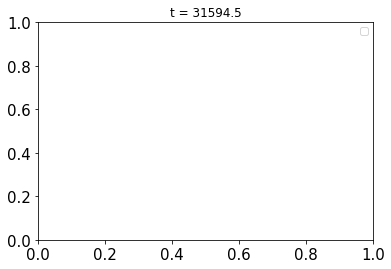

In [18]:


# make animation of the Fourier frequency spectrum over time
Ntotanim = Ntotkeep[0::1000]
Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = 0,xmax = 250,ymin = -20, ymax = 10)
    
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(np.arange(0,256),np.log(np.abs(np.fft.fft(Ntotanim[n])[0:256])))
    lineList[1][0].set_data(np.arange(0,256),np.log(np.abs(np.fft.fft(Fliqanim[n])[0:256])))
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

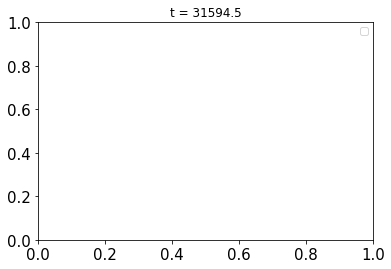

In [19]:
# animation of facet depth over time

Ntotanim = Ntotkeep[0::1000]
Niceanim = Nicekeep[0::1000]
Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = min(x-xmid),xmax = max(x-xmid),ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(x-xmid,Niceanim[n]-min(Niceanim[n]))
    lineList[1][0].set_data(x-xmid,Fliqanim[n]+Niceanim[n]-min(Niceanim[n]))
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

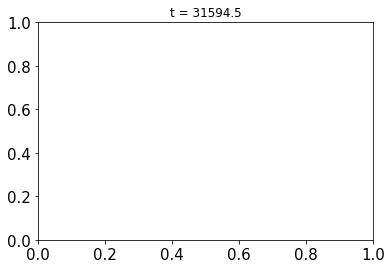

In [20]:
Ntotanim = Ntotkeep[0::1000]
Niceanim = Nicekeep[0::1000]
Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

maxK = 64
maxInd = np.shape(Niceanim[0])[0]
step = int(512/(2*maxK))
indices = np.concatenate([np.arange(0,maxK),np.arange(maxInd-maxK,maxInd)])

xred = np.linspace(0, xmax, maxK*2)

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = min(x-xmid),xmax = max(x-xmid),ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[],[],[]) for i in range(4)]

legendList = ["Total Depth","Total Depth (Fourier)","QLL Depth","QLL Depth (Fourier)"]

# define function to draw each frame
def makeFrame(n):
    NiceFreq = np.fft.fft(Niceanim[n])/(512)
    NiceFreqTrunc = NiceFreq[indices]
    Nice2 = np.real(np.fft.ifft(NiceFreqTrunc)*(2*maxK))
    
    lineList[0][0].set_data(x-xmid,Niceanim[n]-min(Niceanim[n]))
    lineList[1][0].set_data(xred-xmid,Nice2-min(Nice2))
    
    FliqFreq = np.fft.fft(Fliqanim[n])/(512)
    FliqFreqTrunc = FliqFreq[indices]
    Fliq2 = np.real(np.fft.ifft(FliqFreqTrunc)*(2*maxK))
    
    lineList[2][0].set_data(x-xmid,Fliqanim[n]+Niceanim[n]-min(Niceanim[n]))
    lineList[3][0].set_data(xred-xmid,Fliq2+Nice2-min(Nice2))
    plt.title('t = '+str(round(tanim[n],1)))
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

In [21]:
nu_kin

49

In [22]:
nQLL0 = fm.fftnorm(Fliqanim[0])[0:64]



In [23]:
k = np.arange(0,64)
sigmastepRed = sigmastep[0::4] # the 8 used to be 4 but this led tothe wrong size for sigmastepFFT breaking nTotRHS (128 instead of 64)

print(sigmastep.size)

#changed back to 4
sigmastep_FFT = fm.fftnorm(sigmastepRed)
fm.nTotRHS(nQLL0,nu_kin,sigmastep_FFT,k,D)

myN = np.concatenate((Ntot,[*Fliq,*Ntot][maxK:]))
params = {'N' : 64,
         'nu_kin' : nu_kin,
         'sigmastep' : sigmastepRed,
         'sigmastep_FFT' : sigmastep_FFT, # too long
         'k' : k,
         'D' : D,
         'ICNT' : Ntotanim[0],
         'ICNQLL' : Fliqanim[0],
         'endtime' : tanim[-1],
         'timesteps' : tanim,
         'counter' : 0,
         'Nstar' : Nstar}
q 
out = fm.runSim(params)

realSols = fm.makeReal(out.y)
nTotFourier = realSols[0]
nQLLFourier = realSols[1]

512


TypeError: nTotRHS() takes 4 positional arguments but 5 were given

In [ ]:
maxK = 64
xRed = np.linspace(0,50,maxK*2)

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = -25,xmax = 25,ymin = 0, ymax = 1000)
    
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(np.arange(0,maxK),np.log(np.abs(out.y[0:maxK,n])))
    lineList[1][0].set_data(np.arange(0,maxK),np.log(np.abs())) #TODO: Jake do you know how to finish this? -max
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

plt.close()
HTML(anim.to_jshtml())

In [8]:
x = np.array([1,2,3,4,5])

In [13]:
x[-1]

5

In [ ]:
#after finding new NQLL and NTot, we overwrite NQLL with the following:

fqll_last = 1
fstar = Nstar/Nbar
fqll_last = 1 + fstar*np.sin(2*np.pi*(Ntot-Nbar))

NQLL = Nbar + Nstar * np.sin(2*np.pi*(Ntot - Nbar))